In [71]:
# ============================================
# ROP Prediction    AI/ML Engineer Assignment
# ============================================


!pip install -q scikit-learn scipy

# ---- 1. Imports ----
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

from scipy.signal import savgol_filter  # Savitzky–Golay filter

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For nicer plots
plt.rcParams["figure.figsize"] = (8, 5)



In [72]:
# ---- 2. Upload the CSV file ----
print("Please upload your dataset CSV file...")
uploaded = files.upload()

Please upload your dataset CSV file...


Saving Data-Set-AI-ML-Assignment-1.csv to Data-Set-AI-ML-Assignment-1 (2).csv


In [73]:
# Get the first uploaded file name
filename = list(uploaded.keys())[0]
print(f"Using file: {filename}")

Using file: Data-Set-AI-ML-Assignment-1 (2).csv


In [74]:
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("\n=== First few rows of the raw data ===")
print(df.head())
print("\nData types:")
print(df.dtypes)


print("\n--- Column Names ---")
print(df.columns.tolist())

print("\n--- Info ---")
print(df.info())


=== First few rows of the raw data ===
   depth        RPM      Flow       WOB        ROP well
0  25.96  54.947292  2.711315  10.80726  17.310000    A
1  26.27  54.947292  2.711315  10.80726  18.630000    A
2  26.59  61.540000  2.711315  10.80726   5.660000    A
3  26.90  60.230000  2.711315  10.80726  11.670000    A
4  27.24  61.750000  2.711315  10.80726  12.804158    A

Data types:
depth    float64
RPM      float64
Flow     float64
WOB      float64
ROP      float64
well      object
dtype: object

--- Column Names ---
['depth', 'RPM', 'Flow', 'WOB', 'ROP', 'well']

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7311 entries, 0 to 7310
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   depth   7311 non-null   float64
 1   RPM     7311 non-null   float64
 2   Flow    7311 non-null   float64
 3   WOB     7311 non-null   float64
 4   ROP     7311 non-null   float64
 5   well    7311 non-null   object 
dtypes: fl

In [75]:
print("\n--- Summary statistics (numeric columns) ---")
display(df.describe())


--- Summary statistics (numeric columns) ---


,depth,RPM,Flow,WOB,ROP
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,1168.864378,57.169230,2.734865,10.775011,10.352387
std,654.527243,21.055557,0.412798,3.745654,10.448501
min,25.960000,1.690000,1.665580,0.181410,0.220000
25%,600.545000,39.920000,2.356950,8.609975,3.480000
50%,1173.990000,53.280000,2.659360,10.807260,5.490000
75%,1734.710000,74.985000,3.099950,13.460320,12.804158
max,2296.940000,119.610000,4.049060,20.698410,47.400000


In [76]:
# ============================================================
# 4. IDENTIFY ROP (TARGET) COLUMN
# ============================================================

candidate_rop_cols = [c for c in df.columns if "rop" in c.lower()]
print("Candidate ROP columns detected:", candidate_rop_cols)

if len(candidate_rop_cols) == 0:
    # If nothing is found, you MUST manually set the column name here.
    # Example: ROP_COLUMN = "ROP_m_per_hr"
    raise ValueError("No ROP column automatically detected. Please set ROP_COLUMN manually.")
else:
    ROP_COLUMN = candidate_rop_cols[0]  # Use the first match
    print("Using ROP column:", ROP_COLUMN)

# Check for missing values in ROP
print("\nMissing values in ROP:", df[ROP_COLUMN].isna().sum())


Candidate ROP columns detected: ['ROP']
Using ROP column: ROP

Missing values in ROP: 0


In [77]:
df.isnull()

,depth,RPM,Flow,WOB,ROP,well
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
7306,False,False,False,False,False,False
7307,False,False,False,False,False,False
7308,False,False,False,False,False,False
7309,False,False,False,False,False,False


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7311 entries, 0 to 7310
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   depth   7311 non-null   float64
 1   RPM     7311 non-null   float64
 2   Flow    7311 non-null   float64
 3   WOB     7311 non-null   float64
 4   ROP     7311 non-null   float64
 5   well    7311 non-null   object 
dtypes: float64(5), object(1)
memory usage: 342.8+ KB


In [79]:
print(df.isna().sum())       # missing values
print(df.describe())         # summary statistics
print(df['well'].value_counts())


depth    0
RPM      0
Flow     0
WOB      0
ROP      0
well     0
dtype: int64
             depth          RPM         Flow          WOB          ROP
count  7311.000000  7311.000000  7311.000000  7311.000000  7311.000000
mean   1168.864378    57.169230     2.734865    10.775011    10.352387
std     654.527243    21.055557     0.412798     3.745654    10.448501
min      25.960000     1.690000     1.665580     0.181410     0.220000
25%     600.545000    39.920000     2.356950     8.609975     3.480000
50%    1173.990000    53.280000     2.659360    10.807260     5.490000
75%    1734.710000    74.985000     3.099950    13.460320    12.804158
max    2296.940000   119.610000     4.049060    20.698410    47.400000
well
A    7311
Name: count, dtype: int64


###2. Exploratory Data Analysis (EDA)

In [80]:
import seaborn as sns

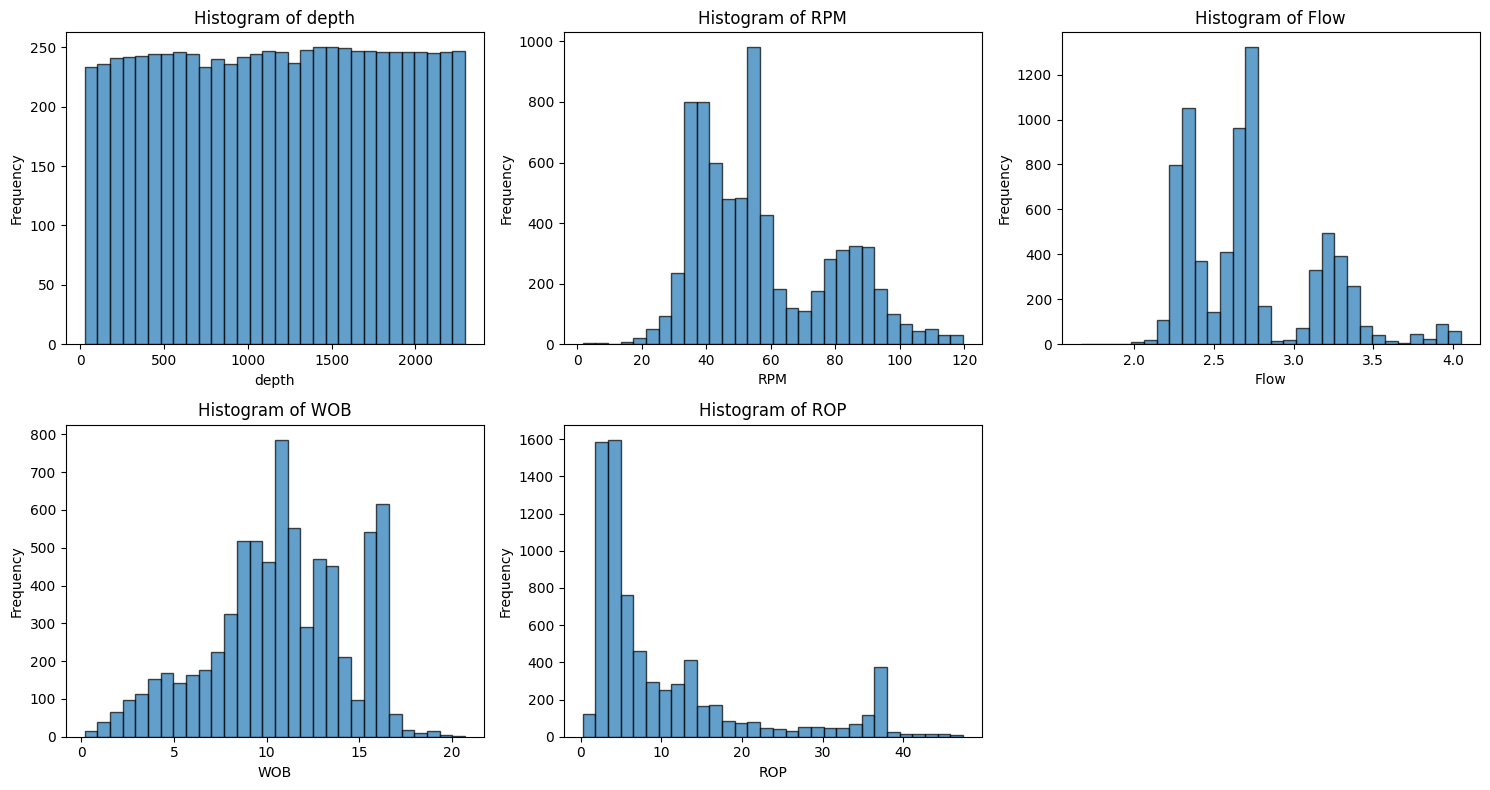

In [81]:


# Make sure numeric columns are correctly identified
numeric_cols = ['depth', 'RPM', 'Flow', 'WOB', 'ROP']

# --------------------------------
# 1. Histograms for key variables
# --------------------------------
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



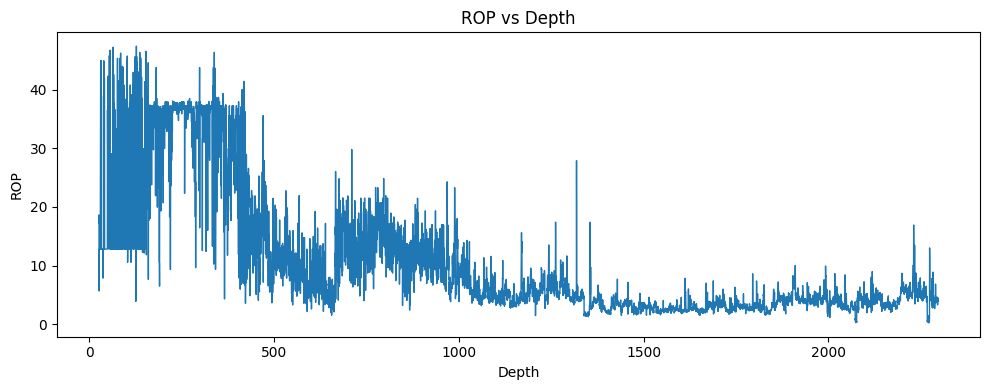

In [82]:
# -----------------------
# 2. ROP vs Depth
# -----------------------
df_sorted = df.sort_values("depth")

plt.figure(figsize=(10, 4))
plt.plot(df_sorted['depth'], df_sorted['ROP'], linewidth=1)
plt.title("ROP vs Depth")
plt.xlabel("Depth")
plt.ylabel("ROP")
plt.tight_layout()
plt.show()

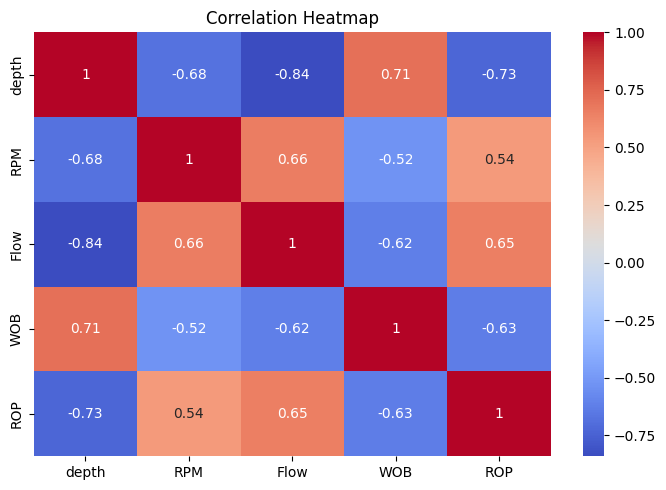

In [83]:
# -----------------------
# 3. Correlation Heatmap
# -----------------------
plt.figure(figsize=(7, 5))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [84]:
# Quick outlier check
Q1, Q3 = df['ROP'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

print(f"\nEstimated ROP outliers using IQR method: {sum((df['ROP'] < lower) | (df['ROP'] > upper))}")
print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")


Estimated ROP outliers using IQR method: 848
Lower bound: -10.51, Upper bound: 26.79


In [85]:
# --- IQR-based bounds for ROP ---
Q1, Q3 = df['ROP'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1, "Q3:", Q3, "IQR:", IQR)
print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

# Count how many outliers we have (for info)
n_outliers = ((df['ROP'] < lower_bound) | (df['ROP'] > upper_bound)).sum()
print("Number of ROP outliers:", n_outliers)

Q1: 3.48 Q3: 12.80415812 IQR: 9.32415812
Lower bound: -10.51, Upper bound: 26.79
Number of ROP outliers: 848


In [86]:
# --- Cap outliers instead of removing them ---
df['ROP'] = df['ROP'].clip(lower=lower_bound, upper=upper_bound)

print("\nOutlier handling method: Capping (Winsorization)")
print("Any ROP values above the upper bound are now capped at:", round(upper_bound, 2))



Outlier handling method: Capping (Winsorization)
Any ROP values above the upper bound are now capped at: 26.79


# ============================================
# Savitzky–Golay (SG) filtering in preprocessing
# ============================================

In [88]:


# SG filter assumes the data is ordered along the "x" axis.
# In our case, the natural order is increasing depth.
df = df.sort_values('depth').reset_index(drop=True)

In [89]:
# -----------------------------------------
# 3. Choose SG filter parameters
# -----------------------------------------


window_length = 51       # must be odd and < number of rows
polyorder = 3

# -----------------------------------------
# 4. Apply SG filter to selected columns
# -----------------------------------------

cols_to_smooth = ['ROP', 'RPM', 'Flow', 'WOB']

for col in cols_to_smooth:
    df[col + '_sg'] = savgol_filter(
        df[col].values,
        window_length=window_length,
        polyorder=polyorder
    )



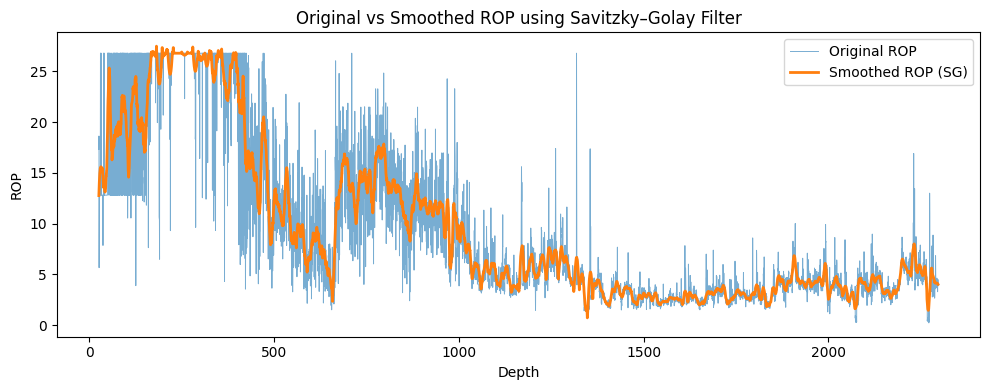

In [90]:
# -----------------------------------------
# 5. Plot original vs smoothed ROP
# -----------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(df['depth'], df['ROP'], label='Original ROP', linewidth=0.7, alpha=0.6)
plt.plot(df['depth'], df['ROP_sg'], label='Smoothed ROP (SG)', linewidth=2)
plt.title("Original vs Smoothed ROP using Savitzky–Golay Filter")
plt.xlabel("Depth")
plt.ylabel("ROP")
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
# -----------------------------------------
# 6. Quick check of new columns
# -----------------------------------------
print(df[['depth', 'RPM', 'RPM_sg', 'Flow', 'Flow_sg',
          'WOB', 'WOB_sg', 'ROP', 'ROP_sg']].head())

   depth        RPM     RPM_sg      Flow   Flow_sg       WOB     WOB_sg  \
0  25.96  54.947292  54.258937  2.711315  2.405960  10.80726  10.328821   
1  26.27  54.947292  54.986533  2.711315  2.477782  10.80726  10.209328   
2  26.59  61.540000  55.748672  2.711315  2.548912  10.80726  10.099665   
3  26.90  60.230000  56.540962  2.711315  2.619219  10.80726   9.999558   
4  27.24  61.750000  57.359007  2.711315  2.688569  10.80726   9.908734   

         ROP     ROP_sg  
0  17.310000  12.761345  
1  18.630000  13.150469  
2   5.660000  13.505490  
3  11.670000  13.827668  
4  12.804158  14.118265  


In [92]:
# "well" has only one value, so it cannot help the model.
if 'well' in df.columns:
    df = df.drop(columns=['well'])


In [93]:
print("Columns before feature engineering:\n", df.columns.tolist())


Columns before feature engineering:
 ['depth', 'RPM', 'Flow', 'WOB', 'ROP', 'ROP_sg', 'RPM_sg', 'Flow_sg', 'WOB_sg']


In [94]:

# 1. Basic normalized features

# Normalize by max value (simple scale 0–1), useful because
# RPM, Flow, WOB and depth are on very different scales.
df['depth_norm'] = df['depth'] / df['depth'].max()
df['RPM_norm']   = df['RPM']   / df['RPM'].max()
df['Flow_norm']  = df['Flow']  / df['Flow'].max()
df['WOB_norm']   = df['WOB']   / df['WOB'].max()


# 2. Transformations of depth


df['log_depth'] = np.log1p(df['depth'])


# 3. Ratios between parameters


df['rpm_to_flow'] = df['RPM'] / df['Flow']
df['wob_to_rpm']  = df['WOB'] / df['RPM']
df['wob_to_flow'] = df['WOB'] / df['Flow']


ratio_cols = ['rpm_to_flow', 'wob_to_rpm', 'wob_to_flow']
df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], np.nan).fillna(0)


# 4. Interaction (product) terms


df['mech_input']      = df['WOB'] * df['RPM']
df['hyd_input']       = df['Flow'] * df['RPM']
df['wob_flow_inter']  = df['WOB'] * df['Flow']


# 5. Changes (derivatives) w.r.t depth

# How fast the settings are changing as we drill deeper.
df['rpm_change']  = df['RPM'].diff().fillna(0)
df['flow_change'] = df['Flow'].diff().fillna(0)
df['wob_change']  = df['WOB'].diff().fillna(0)


# 6. Rolling (past) averages


window = 21

df['rpm_roll_mean']  = df['RPM'].rolling(window, min_periods=1).mean()
df['flow_roll_mean'] = df['Flow'].rolling(window, min_periods=1).mean()
df['wob_roll_mean']  = df['WOB'].rolling(window, min_periods=1).mean()


# 7. Decide which columns are features

# Base raw features
base_features = ['depth', 'RPM', 'Flow', 'WOB']

# Smoothed versions from SG filter
smoothed_features = ['RPM_sg', 'Flow_sg', 'WOB_sg']

# Engineered features created above
engineered_features = [
    'depth_norm', 'RPM_norm', 'Flow_norm', 'WOB_norm',
    'log_depth',
    'rpm_to_flow', 'wob_to_rpm', 'wob_to_flow',
    'mech_input', 'hyd_input', 'wob_flow_inter',
    'rpm_change', 'flow_change', 'wob_change',
    'rpm_roll_mean', 'flow_roll_mean', 'wob_roll_mean'
]

feature_cols = base_features + smoothed_features + engineered_features

print(f"\nTotal number of features: {len(feature_cols)}")
print("Feature columns:")
print(feature_cols)

# Quick look at the engineered feature matrix
df[feature_cols].head()


Total number of features: 24
Feature columns:
['depth', 'RPM', 'Flow', 'WOB', 'RPM_sg', 'Flow_sg', 'WOB_sg', 'depth_norm', 'RPM_norm', 'Flow_norm', 'WOB_norm', 'log_depth', 'rpm_to_flow', 'wob_to_rpm', 'wob_to_flow', 'mech_input', 'hyd_input', 'wob_flow_inter', 'rpm_change', 'flow_change', 'wob_change', 'rpm_roll_mean', 'flow_roll_mean', 'wob_roll_mean']


,depth,RPM,Flow,WOB,RPM_sg,Flow_sg,WOB_sg,depth_norm,RPM_norm,Flow_norm,...,wob_to_flow,mech_input,hyd_input,wob_flow_inter,rpm_change,flow_change,wob_change,rpm_roll_mean,flow_roll_mean,wob_roll_mean
0,25.96,54.947292,2.711315,10.80726,54.258937,2.405960,10.328821,0.011302,0.459387,0.669616,...,3.985984,593.829668,148.979444,29.301892,0.000000,0.0,0.0,54.947292,2.711315,10.80726
1,26.27,54.947292,2.711315,10.80726,54.986533,2.477782,10.209328,0.011437,0.459387,0.669616,...,3.985984,593.829668,148.979444,29.301892,0.000000,0.0,0.0,54.947292,2.711315,10.80726
2,26.59,61.540000,2.711315,10.80726,55.748672,2.548912,10.099665,0.011576,0.514505,0.669616,...,3.985984,665.078780,166.854356,29.301892,6.592708,0.0,0.0,57.144861,2.711315,10.80726
3,26.90,60.230000,2.711315,10.80726,56.540962,2.619219,9.999558,0.011711,0.503553,0.669616,...,3.985984,650.921270,163.302532,29.301892,-1.310000,0.0,0.0,57.916146,2.711315,10.80726
4,27.24,61.750000,2.711315,10.80726,57.359007,2.688569,9.908734,0.011859,0.516261,0.669616,...,3.985984,667.348305,167.423732,29.301892,1.520000,0.0,0.0,58.682917,2.711315,10.80726


In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =========================================
# 1. Define target and feature matrix
# =========================================

# Target (raw ROP)
y = df['ROP']

# Feature matrix using engineered + raw + smoothed features
X = df[feature_cols].copy()

print("Number of features being used:", X.shape[1])
print("Feature names:", feature_cols)

# =========================================
# 2. Train/Test Split (80% / 20%)
# =========================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,    # ensures reproducibility
    shuffle=True        # good for drilling data (not strictly time-series)
)

print("\nShapes after train/test split:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)

Number of features being used: 24
Feature names: ['depth', 'RPM', 'Flow', 'WOB', 'RPM_sg', 'Flow_sg', 'WOB_sg', 'depth_norm', 'RPM_norm', 'Flow_norm', 'WOB_norm', 'log_depth', 'rpm_to_flow', 'wob_to_rpm', 'wob_to_flow', 'mech_input', 'hyd_input', 'wob_flow_inter', 'rpm_change', 'flow_change', 'wob_change', 'rpm_roll_mean', 'flow_roll_mean', 'wob_roll_mean']

Shapes after train/test split:
X_train: (5848, 24)
X_test:  (1463, 24)
y_train: (5848,)
y_test:  (1463,)


In [96]:



# 3. Standard Scaling


scaler = StandardScaler()

# Fit on training data only (VERY important)
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print("\nShapes after scaling:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)


Shapes after scaling:
X_train_scaled: (5848, 24)
X_test_scaled:  (1463, 24)


In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ===========================================================
# 1. Train Linear Regression Model
# ===========================================================

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# ===========================================================
# 2. Predictions
# ===========================================================

y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred  = lr_model.predict(X_test_scaled)

# ===========================================================
# 3. Evaluation Metrics
# ===========================================================

def evaluate(y_true, y_pred, dataset_name):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    print(f"\n===== {dataset_name} Performance =====")
    print("MAE :", round(mae, 4))
    print("MSE :", round(mse, 4))
    print("RMSE:", round(rmse, 4))
    print("R²  :", round(r2, 4))

evaluate(y_train, y_train_pred, "Training Set")
evaluate(y_test,  y_test_pred,  "Test Set")


===== Training Set Performance =====
MAE : 3.1571
MSE : 17.2506
RMSE: 4.1534
R²  : 0.7306

===== Test Set Performance =====
MAE : 3.1701
MSE : 17.3406
RMSE: 4.1642
R²  : 0.7377


In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Build and Train Random Forest Model


rf_model = RandomForestRegressor(
    n_estimators=200,     # number of trees
    max_depth=None,       # let trees
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1             # use all CPU cores
)

rf_model.fit(X_train_scaled, y_train)


# 2. Predictions

rf_y_train_pred = rf_model.predict(X_train_scaled)
rf_y_test_pred  = rf_model.predict(X_test_scaled)

# ===========================================================
# 3. Evaluation Function
# ===========================================================

def evaluate_model(y_true, y_pred, title):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    print(f"\n===== {title} =====")
    print("MAE :", round(mae, 4))
    print("MSE :", round(mse, 4))
    print("RMSE:", round(rmse, 4))
    print("R²  :", round(r2, 4))

# 4. Evaluate on Train & Test Sets


evaluate_model(y_train, rf_y_train_pred, "Random Forest - Training Set")
evaluate_model(y_test,  rf_y_test_pred,  "Random Forest - Test Set")


# 5. Feature Importance


importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\n===== Top Feature Importances =====")
for idx in sorted_idx[:15]:   # show top 15
    print(f"{feature_cols[idx]}: {importances[idx]:.4f}")



===== Random Forest - Training Set =====
MAE : 0.4917
MSE : 0.8411
RMSE: 0.9171
R²  : 0.9869

===== Random Forest - Test Set =====
MAE : 1.3937
MSE : 6.57
RMSE: 2.5632
R²  : 0.9006

===== Top Feature Importances =====
depth_norm: 0.3115
depth: 0.2762
log_depth: 0.2721
WOB_sg: 0.0163
rpm_roll_mean: 0.0129
RPM_sg: 0.0121
wob_change: 0.0108
Flow_sg: 0.0086
wob_roll_mean: 0.0083
flow_roll_mean: 0.0081
flow_change: 0.0075
Flow: 0.0073
hyd_input: 0.0072
wob_to_rpm: 0.0063
Flow_norm: 0.0060


In [100]:
!pip install xgboost



===== XGBoost - Training Set Performance =====
MAE : 0.5349
MSE : 0.6121
RMSE: 0.7824
R²  : 0.9904

===== XGBoost - Test Set Performance =====
MAE : 1.464
MSE : 6.9891
RMSE: 2.6437
R²  : 0.8943


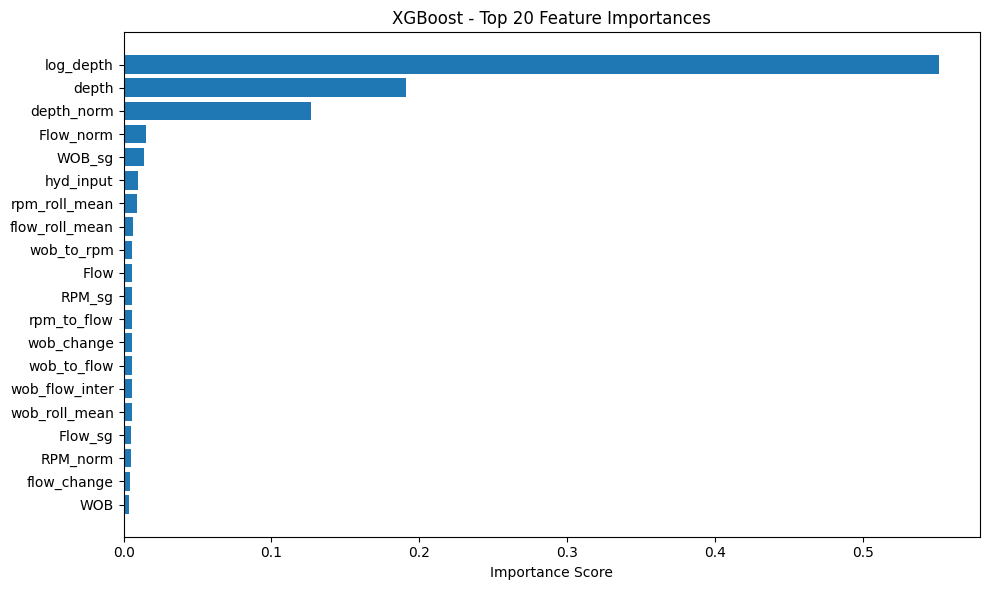

In [103]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# 1. Create the XGBoost Model


xgb_model = XGBRegressor(
    n_estimators=200,     # number of boosting trees
    learning_rate=0.05,   # slow learning → better accuracy
    max_depth=8,          # deeper trees capture more nonlinear patterns
    subsample=0.8,        # prevents overfitting
    colsample_bytree=0.8, # prevents overfitting
    reg_alpha=0.1,        # L1 regularization
    reg_lambda=1.0,       # L2 regularization
    random_state=42,
    n_jobs=-1
)


# 2. Train the Model


xgb_model.fit(X_train_scaled, y_train)

# 3. Predictions

xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred  = xgb_model.predict(X_test_scaled)

# 4. Evaluation Function

def evaluate(y_true, y_pred, dataset_name):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    print(f"\n===== XGBoost - {dataset_name} Performance =====")
    print("MAE :", round(mae, 4))
    print("MSE :", round(mse, 4))
    print("RMSE:", round(rmse, 4))
    print("R²  :", round(r2, 4))

evaluate(y_train, xgb_train_pred, "Training Set")
evaluate(y_test,  xgb_test_pred,  "Test Set")

# 5. Feature Importance Plot

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
importance_vals = xgb_model.feature_importances_
sorted_idx = np.argsort(importance_vals)

plt.barh(np.array(feature_cols)[sorted_idx][-20:], importance_vals[sorted_idx][-20:])
plt.title("XGBoost - Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [104]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Helper function to compute metrics
def get_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

# ---------------------------------------
# Compute metrics for each model
# ---------------------------------------

results = []

# 1) Linear Regression
lr_train_mae, lr_train_rmse, lr_train_r2 = get_metrics(y_train, y_train_pred)
lr_test_mae,  lr_test_rmse,  lr_test_r2  = get_metrics(y_test,  y_test_pred)

results.append([
    "Linear Regression",
    lr_train_mae, lr_train_rmse, lr_train_r2,
    lr_test_mae,  lr_test_rmse,  lr_test_r2
])

# 2) Random Forest
rf_train_mae, rf_train_rmse, rf_train_r2 = get_metrics(y_train, rf_y_train_pred)
rf_test_mae,  rf_test_rmse,  rf_test_r2  = get_metrics(y_test,  rf_y_test_pred)

results.append([
    "Random Forest",
    rf_train_mae, rf_train_rmse, rf_train_r2,
    rf_test_mae,  rf_test_rmse,  rf_test_r2
])

# 3) XGBoost
xgb_train_mae, xgb_train_rmse, xgb_train_r2 = get_metrics(y_train, xgb_train_pred)
xgb_test_mae,  xgb_test_rmse,  xgb_test_r2  = get_metrics(y_test,  xgb_test_pred)

results.append([
    "XGBoost",
    xgb_train_mae, xgb_train_rmse, xgb_train_r2,
    xgb_test_mae,  xgb_test_rmse,  xgb_test_r2
])

# ---------------------------------------
# Build comparison table
# ---------------------------------------

columns = [
    "Model",
    "Train MAE", "Train RMSE", "Train R²",
    "Test MAE",  "Test RMSE",  "Test R²"
]

comparison_df = pd.DataFrame(results, columns=columns)

# Round for nicer display
comparison_df_rounded = comparison_df.copy()
for col in comparison_df.columns[1:]:
    comparison_df_rounded[col] = comparison_df[col].round(4)

comparison_df_rounded


,Model,Train MAE,Train RMSE,Train R²,Test MAE,Test RMSE,Test R²
0,Linear Regression,3.1571,4.1534,0.7306,3.1701,4.1642,0.7377
1,Random Forest,0.4917,0.9171,0.9869,1.3937,2.5632,0.9006
2,XGBoost,0.5349,0.7824,0.9904,1.4640,2.6437,0.8943


In [70]:
import joblib

# Save model
joblib.dump(rf_model, "random_forest_model.pkl")

# Download model
from google.colab import files
files.download("random_forest_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

models = {
    "linear_regression": lr_model,
    "random_forest": rf_model,
    "xgboost": xgb_model
}

joblib.dump(models, "all_models.pkl")

from google.colab import files
files.download("all_models.pkl")
